## <center> Tutorial in Scikit-Learn and TensorFlow</center>

## Introduction

What is Machine Learning ? "Machine learning is a field that develops algorithms designed to be applied to datasets, with the main areas of focus being prediction (regression), classification, and clustering or grouping tasks. These tasks are divided into two main branches, supervised and unsupervised ML." (Athey 2019).
 
* supervised learning: the model is learning to associate data with labels (classification) or values (regression)
* unsupervised learning: the model works on the data only to recognise sub-groups (classification)
* We may add reinforcement learning: the model interacts with an environment and determines the optimal policy (for the connection with dynamic programming, check Bertsekas http://www.mit.edu/~dimitrib/RLbook.html)

The use of machine learning in economics is not always natural: econometricians are concerned with causal inference, which is something ML was not built to do. ML however brings economics a set of tools that can be used either as an intermediary step (when one needs to classify observations before conducting regressions), or as a central method, in particular when the goal of the paper is to provide predictions. 

### Applications

For example, Björkegren and Grissen (2019), attempt to predict individual credit risk based on mobile phone usage. Example where machine learning would be used as an intermediary step: you want to assess the impact of an agricultural policy on the crop choice by farmers. Starting from a dataset of satellite crop images, you can classify the fields using image recognition, and then identify the treatment effect using traditional econometric methods. Image recognition can also be used for urban economics using satellite images.

Otherwise, in policymaking, the prediction aspect may be important. For example, you may want to install wind turbines in areas where the wind turbine project will not generate too much backlash. We will conduct such analysis at the end of the notebook.

Here, we will see two packages, Scikit-Learn and Tensorflow 2, which can be used for machine learnings applications. We will briefly review the general setup for adapting data to a machine learning project, and present some methods, in particular Ridge, Lasso, Elasticnet, and Neural networks, for regression and classification. I will also present PCA, a method allowing dimensionality reduction.

Applications will be done on MNIST (the standard toy dataset for deep learning applications) and a dataset on the Beijing housing market.

### References:

The Scikit-Learn documentation:

* https://scikit-learn.org/stable/index.html

A review of machine learning applications in economics:
* Machine Learning Methods That Economists Should Know About, Athey & Imbens, 2019, Annual Review of Economics, Vol. 11:685-725


Two textbooks on machine learning applications (not too much theory)
* Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition, A. Géron, 2019, O'Reilly Media, Inc.
* Machine Learning for Economics and Finance in TensorFlow 2: Deep Learning Models for Research and Industry, I. Hull, 2020, Apress, 1st ed.


Additional: More theoretical resources:

* Foundations of Machine Learning, Mohri et al., MIT Press, Second Edition, 2018
* Deep Learning, Goodfellow et al, 2016, MIT Press, http://www.deeplearningbook.org

In [ ]:
#!pip install tensorflow
#!pip install --upgrade tensorflow-probability

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score
from sklearn.linear_model import SGDClassifier
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
tfd = tfp.distributions

from math import *

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)

#### Motivation: MNIST

To begin with, we will solve a number classification problem. The MNIST dataset contains input of hand-written numbers, and the output is a vector containing the "actual" number that was written. We will train a model on a subset of the input, and then test it. The strength of scikit learn is that we can simply import the method and implement it immediately.

In [ ]:
mnist = pd.read_csv("mnist_df.csv")

In [ ]:
X, y = mnist.iloc[:, 1:785].to_numpy(), mnist['target'].to_numpy().astype(int)

In [ ]:
%matplotlib inline
num = X[9, :].reshape(28, 28)
plt.imshow(num, cmap="binary")
plt.show()

The MNIST dataset is to machine/deep learning what the auto-mpg stata dataset is to econometrics. We will start from here, and then move to more econometric frameworks.

In [ ]:
#Step 1: Data splitting, usually train/test, sometimes train/validation/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
#Step 2: Model building and fitting
sgd_class = SGDClassifier(random_state=42)
sgd_class.fit(X_train, y_train)

In [ ]:
#Step 3: out of sample prediction
y_predict = sgd_class.predict(X_test)

In [ ]:
#Step 4: Testing. Depending on the task, find the right test (here the task is multilabel classification)
confusion_mnist = confusion_matrix(y_predict, y_test)
plt.matshow(confusion_mnist, cmap = plt.cm.gray)

In [ ]:
accuracy_score(y_predict, y_test)

The stochastic classifier is already quite good. We see on the confusion matrix that 7 are sometimes mistaken for 9. Now let us check if we can do better with a neural network built with Keras.

In [ ]:
#Model training
model_mnist = keras.models.Sequential()
model_mnist.add(keras.layers.Dense(200, activation="relu"))
model_mnist.add(keras.layers.Dense(200, activation="relu"))
model_mnist.add(keras.layers.Dense(200, activation="relu"))
model_mnist.add(keras.layers.Dense(200, activation="relu"))
model_mnist.add(keras.layers.Dense(10, activation="softmax"))
model_mnist.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
#Model fitting
model_mnist.fit(X_train, y_train, batch_size=100, epochs=10, validation_split=0.2)

In [ ]:
y_pred = model_mnist.predict(X_test)
class_prediction_nn = np.argmax(y_pred, axis=1)

confusion_mnist_nn = confusion_matrix(class_prediction_nn, y_test)
plt.matshow(confusion_mnist_nn, cmap = plt.cm.gray)

In [ ]:
#Out-of-sample prediction:
accuracy_score(class_prediction_nn, y_test)

The power of neural networks/perceptrons for image classification like the one above is impressive: with a simple, 4-layers-perceptron, we get around 95% accuracy out of the sample, the confusion matrix shows that classification is nearly perfect.

## General Introduction to the Machine Learning framework

As mentioned earlier, Machine learning is most often concerned with classification and regression/prediction tasks. The goal is accuracy/precision of the model, not too much its interpretability. To test how well the model performs, we need to test it out of the sample. This leads to one big concern: overfitting.

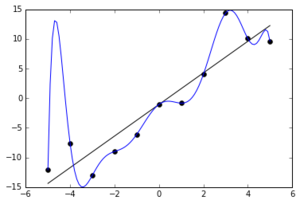


Overfitting happens if the model trains too much and reaches 100% accuracy/$R^2$ on the training set. However, as one can expect, the regression line above will definitely not be optimal when we provide the model with a testing sample. So, the model needs to be constrained: either by design (OLS), or by avoiding training indefinitely on the same subsample.

Another form of overfitting may arise: if the scientist building the model systematically looks at what his model parameters yield once the trained model is tested on the testing sample, he will build a model that is designed to give good results on the testing sample. But then, the model would simply be overfitting on the testing sample. This temptation to cheat is why the testing sample is generally reserved until the very last step: the model should first be trained and tested on a subset of the training set and validated (pre-tested) on a subset of the training set called the validation set.

### Implementation of Scikit Learn

For now, let's go over some simple regression designs: OLS, Ridge, Lasso and ElasticNet. These tools focus on estimating the parameter of a Linear Regression equation. The functional form is thus the following, for each observation $i$.

$$y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + ... + \beta_j x_{ij} + \epsilon_i$$

Where __$\beta$__ = ($\beta_0$, ..., $\beta_j$) are the parameters we want to estimate, and **($x_i$; $y_i$)** is the data for individual **i**.

In matrix form, it can be rewritten $ \begin{align}
y = X \beta + \epsilon
\end{align} $


### The simplest method: OLS

We all know here about OLS: it can be implemented very simply with ScikitLearn, and we will use it as a benchmark to which subsequent methods will be compared.

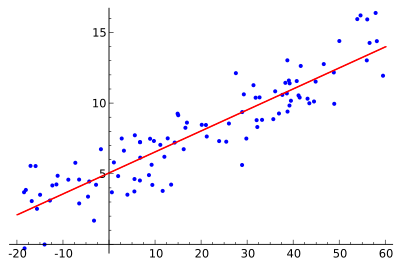

#### The example at hand: the Beijing Housing market

To present the use of scikit learn methods, we will use a dataset on the housing market in Beijing. The original dataset can be found here: https://www.kaggle.com/ruiqurm/lianjia. We are using a cleaned and pre-processed version of the data, to avoid formatting issues.

In [ ]:
beijing_data = pd.read_csv("data_beijing.csv")

In [ ]:
beijing_data.head()

In [ ]:
varnames = beijing_data.columns
print(varnames)

In [ ]:
y_b = beijing_data['logprice'].to_numpy().reshape(-1, 1)
X_b_short = beijing_data['dist_from_cent'].to_numpy().reshape(-1, 1)

A good practice is to divide the dataset into a training subset and a testing subset. Scikitlearn does that automatically with us with **train_test_split** and we can also do stratified sampling if we want to ensure the representativity of our subsets.

In [ ]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b_short, y_b, test_size=0.3, random_state=42)

In [ ]:
reg = linear_model.LinearRegression()
reg.fit(X_train_b, y_train_b)
y_pred_s = reg.predict(X_train_b) #in-sample prediction

In [ ]:
plt.scatter(X_train_b, y_train_b, s=0.1)
plt.plot(X_train_b, y_pred_s, 'r')
plt.show()

We immediately see that a linear approximation gives us some idea about the housing market structure (the furthest you are from the center, the cheaper housing). However, it is clearly not perfect, as there is a lot of unexplained variance. To measure the accuracy of the model, we can use the $R^2$ directly from sklearn as well.

In [ ]:
y_pred_out = reg.predict(X_test_b) #out-sample prediction
r2_score(y_test_b, y_pred_out)

In [ ]:
features = ['lng', 'lat', 'kitchen', 'renovationcondition', 'buildingstructure', 'ladderratio', 'elevator', 'fiveyearsproperty', 'subway', 'district', 'livingroom_int', 'drawingroom_int', 'bathroom_int', 'construction_int', 'commu_avg', 'logdist_from_cent', 'logfollowers', 'logcommu_avg', 'logladder', 'logdom', 'log_age']
X_b_long = beijing_data[features].to_numpy()

First, let's re-do an OLS regression with multiple predictors. We write it as a function.

In [ ]:
def ols_reg(y, X):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    reg_ols = linear_model.LinearRegression()
    reg_ols.fit(X_train, y_train)
    y_predict = reg_ols.predict(X_test)
    return reg_ols.coef_, reg_ols.coef_.shape, r2_score(y_test, y_predict) 

In [ ]:
coef_ols, size_ols, r2_ols = ols_reg(y_b, X_b_long)

In [ ]:
print(coef_ols)
print(size_ols)
print(r2_ols)

So, we have our 21 coefficients, and a satisfying $R^2$ out of the sample of 74.4%. In traditional econometrics methods, we would try to run t-tests to assess whether the variables are significant, worry about possible endogeneity issues... This is easy in Stata or R, but a bit tedious in Python. So, if we want to reduce the number of coefficients and make the model a bit more interpretable, we should use regularised regressions, such as Ridge, Lasso, and Elasticnet.

### Linear models

The goal of these methods is to improve the efficiency of our predictions, by keeping only the most relevant coefficients. Instead of using 21 features in our data, we may reduce the size of the problem. In OLS, there is by definition no penalisation, thus we solve, given $k$ features:

\begin{align*}
    \min_{\beta} ||X\beta - y||_2^2
\end{align*}

#### Ridge:

\begin{align*}
    \min_{\beta} ||X\beta - y||_2^2 + \alpha ||\beta||_2^2
\end{align*}

Here, $||\cdot||_2^2$ denotes the l2-norm, which develops as $\sum_{j=1}^k \beta_j^2$

Ridge can be used to make the coefficients robust to collinearity (variables that are linear combinations of other variables). In the dataset at hand, it will not be useful. $\alpha$ is the regularisation parameter. Equal to 0, we find back OLS. The larger it is, the most the coefficients will be robust to collinearity.


#### LASSO (Least Absolute Shrinkage and Selection Operator):

\begin{align*}
    \min_{\beta} ||X \beta - y||_2^2 + \alpha ||\beta||_1
\end{align*}

LASSO penalises the coefficients that are close to 0, and thus leads to a restricted set of explanatory variables. Here, $||\cdot||_1$ denotes the l1-norm, which develops as $\sum_{j=1}^k |\beta_j|$. $\alpha$ is the regularisation parameter, but this time, using the l1-norm instead of the l2-norm allows us to bring coefficients that are close to 0 to 0 exactly. Doing so, we can reduce the number of coefficients. Obviously, it will be done at the loss of some precision of the model, which will be reflected by the $R^2$.

#### Elastic-Net

\begin{align*}
    \min_{\beta} ||X \beta - y||_2^2 + \alpha \rho ||\beta||_1 + \frac{\alpha (1 - \rho)}{2} ||\beta||_2^2
\end{align*}

As we can see, Elastic-Net allows us to use a linear combination of l1-norm and l2-norm penalisation. It is using 2 parameters, $\alpha$ and $\rho$, which are respectively the regularisation parameter and the share of l1-norm penalisation in the process.



In [ ]:
def linear_reg(y, X, method, α=0.1, l1_r=0.5):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    if method=="OLS":
        lin_reg = linear_model.LinearRegression()
    elif method=="Ridge":
        lin_reg = linear_model.Ridge(alpha=α)
    elif method=="Lasso":
        lin_reg = linear_model.Lasso(alpha=α)
    elif method=="ElasticNet":
        lin_reg = linear_model.ElasticNet(alpha=α, l1_ratio = l1_r)
    
    lin_reg.fit(X_train, y_train)
    y_predict = lin_reg.predict(X_test)
    
    coef_list = lin_reg.coef_[lin_reg.coef_ != 0]
    coef_ind = np.argwhere(lin_reg.coef_ != 0)
    coef_names = np.array(features)[[coef_ind]]
    
    return coef_list, len(coef_list), r2_score(y_test, y_predict), coef_ind

In [ ]:
regression_ols = linear_reg(y_b, X_b_long, method="OLS")
coefs_ols, nbcoefs_ols, r2_ols = regression_ols[0], regression_ols[1], regression_ols[2]

print(coefs_ols)
print(nbcoefs_ols)
print(r2_ols)

In [ ]:
np.array(features)[[regression_ols[3]]][:, 1]

In [ ]:
regression_elastic = linear_reg(y_b, X_b_long, method="ElasticNet")
coefs_elastic, nbcoefs_elastic, r2_elastic = regression_elastic[0], regression_elastic[1], regression_elastic[2]

print(coefs_elastic)
print(nbcoefs_elastic)
print(r2_elastic)

In [ ]:
np.array(features)[[regression_elastic[3]]]

ElasticNet regression shows us that we can obtain a $R^2$ of 70% with a simpler linear model of only 6 variables instead of 21

## Hyperparameter tuning

As seen earlier, some statistical models imported with Sklearn rely on hyperparameters. For example, for ElasticNet, the regularisation parameter $\alpha$ and the l1-penalisation parameter $\rho$. How to fix these hyperparameters in an optimal manner should not be done by testing how the model performs on the testing set, since it would lead to overfitting again. Instead, we will use a tool sklearn provides: Grid Search.

The idea is to specify a list of hyperparameter values that will be tested on the training set using the Cross-Validation principle (repeated training and validation on the training set). When the number of hyperparameters grows big, and it is time consuming to test every possible combination of values, we may rely on Randomized Grid Search. Let us try these methods using ElasticNet:

In [ ]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b_long, y_b, test_size=0.3, random_state=42)

In [ ]:
#Here, we have two parameters, with 9 possible values each, so 81 possible combinations

parameters = {'alpha': np.logspace(0, 3, 9, base=10)/(10**5), 
              'l1_ratio': np.linspace(0.1, 0.9, 9)}
model_elasticnet = linear_model.ElasticNet()
elasticreg = GridSearchCV(model_elasticnet, parameters, cv=5)
elasticreg

In [ ]:
elasticreg.fit(X_train_b, y_train_b)

In [ ]:
elasticreg.best_params_

In [ ]:
# Exercise 1: Now, instantiate an elasticnet regression of your own. Does it perform better than the one obtained earlier ? (It should)
# What is the issue with doing this with ElasticNet ?


In [ ]:
# Exercise 2: redo the Grid Searching through the following grid (with 400 combinations) using RandomizedSearchCV.
# What is the limitation of this method ?

parameters_randomized = {'alpha': np.logspace(0, 3, 20)/(10**5), 
              'l1_ratio': np.linspace(0.01, 0.1, 20)}


## Support Vector Machines

SVMs are another machine learning that were originally designed to handle classification tasks. In one sentence, a SVM classifier works under the hood by projecting the data to a higher-dimensional space and finding a linear separator between the categories. For this part, we will rely on an example by Aurélien Géron (Hands On Machine Learning) relying on polynomial classification and the Pipeline technique, which can be used to synthesize the building of a machine learning model with Scikit Learn. Here, we see the classification of a noisy nonlinear dataset.

In [ ]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC

X, y = make_moons(n_samples=1000, noise=0.25)

df = pd.DataFrame(dict(X1=X[:, 0], X2=X[:, 1], target = y))
plt.scatter(df['X1'], df['X2'], c=df['target'].map({0:'red', 1:'green'}))

In [ ]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X, y, test_size=0.2)

polynomial_svm_clf = Pipeline([
("poly_features", PolynomialFeatures(degree=3)),
("scaler", StandardScaler()),
("svm_clf", SVC(C=10))
])

polynomial_svm_clf.fit(X_train_svm, y_train_svm)

In [ ]:
y_pred = polynomial_svm_clf.predict(X_test_svm)
print(accuracy_score(y_pred, y_test_svm))

NB: SVMs are versatile and can also be used for regression. 

## Neural Networks: the Multi-Layer Perceptron

I will not go into the inner workings of a neural network here. For details, go to the book "Deep Learning", by Ian Goodfellow et al.

Now let's move away from linear models and try neural networks. If you have lived in a cave for the last 8 years or so you may not have heard of it. It has proved remarkably efficient for detecting nonlinear patterns, and do image recognition.

There is a neural network available in scikitlearn, that we will implement here, but Google has developed a much more advanced tool, TensorFlow, which will give us more control. TensorFlow can be a bit complex to learn and use, but the high-level API Keras makes it easy to build (simple) neural nets.

Tensorflow can be used to do a lot more than deep learning (optimisation, regression tasks...), so I refer the interested student to the resource "Machine Learning for Economics and Finance in TensorFlow 2" (Isaiah Hull), in which the author does nearly everything (OLS, PCA...) in TensorFlow only.

First, it is recommended that we scale the data, and scikitlearn has a tool for this. You may check, by training the model on un-scaled data, that the model is performing clearly worse.

In [ ]:
scaler_b = StandardScaler()
scaler_b.fit(X_train_b)
X_train_bs = scaler_b.transform(X_train_b)
X_test_bs = scaler_b.transform(X_test_b)

In [ ]:
nn_b = MLPRegressor(max_iter=50, activation='relu', early_stopping=True, batch_size=1000)
nn_b.fit(X_train_bs, y_train_b)

In [ ]:
#If our goal was to predict the housing price, we now have a good predictor that clearly outperforms OLS.
#We may gain some additional precision points by tweaking the parameters.
y_pred_o_nn = nn_b.predict(X_test_bs)
r2_score(y_test_b, y_pred_o_nn)

In [ ]:
#This increase in precision is done at the expense of interpretability
coefs_nn = nn_b.coefs_

In [ ]:
coefs_nn[0].shape

Given that there are 100 layers (default) in our neural network, and we have 21 variables, there are 2100 weights in our model that are difficult to interpret. Now let us build a neural network with TensorFlow and Keras. Here, we will build a simple neural network with the simplest way to use the Keras API: Sequential.

In [ ]:
model_beijing_nn = tf.keras.Sequential()
model_beijing_nn.add(tf.keras.layers.Dense(50, activation='relu'))
model_beijing_nn.add(tf.keras.layers.Dense(50, activation='relu'))
model_beijing_nn.add(tf.keras.layers.Dense(50, activation='relu'))
model_beijing_nn.add(tf.keras.layers.Dense(1))
model_beijing_nn.compile(optimizer='adam', loss='mse')

history_beijing = model_beijing_nn.fit(X_train_bs, y_train_b, batch_size=100, epochs=10, validation_split=0.2)

In [ ]:
y_pred_bs = model_beijing_nn.predict(X_test_bs)

In [ ]:
r2_score(y_test_b, y_pred_bs)

In [ ]:
pd.DataFrame(history_beijing.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

We may gain some precision by adding layers to the network, and adding data to the model. We should be careful however to avoid overfitting: if we add too many layers, the model risks becoming "too good" at predicting housing prices within the sample, but being unable to make any meaningful prediction out of the sample. In any case, with our 80% $R^2$ predictor out of the sample, we have a convincing approximation of the housing price in Beijing.

### Dimensionality Reduction: PCA

In computational sciences, the "curse of dimensionality" is often faced. We have so much data available that, geometrically, the dataset becomes an object with too many dimensions to be exploitable. A possible solution is PCA: Principal components analysis. A bit like regularisation, we need to accept to lose some of the noise of the data in order to make the data more "friendly" to the model. I won't go into the details of PCA, but briefly, it consists in projecting the data orthogonally on several consecutive "axis", which are the principal components. The goal of PCA is to obtain a dataset which still allows classification/regression, but relies on a smaller number of variables. Here, we will look at what this means in practice.

In [ ]:
from sklearn.decomposition import PCA

#Two options: first, you can specify the number of variables you want to end up with. Here, we want to plot it, so 2 is good.
pca1 = PCA(n_components=2)
X_reduced_bs = pca1.fit_transform(X_train_bs)

In [ ]:
plt.scatter(X_reduced_bs[:, 0], X_reduced_bs[:, 1], s=0.1)
plt.show()
print(pca1.explained_variance_ratio_)

Issue: we can see with "explained_variance_ratio_" that the two first principal components only explain 0.17 + 0.13 = 30% of the data variance. We would rather aim at something like 90% or 95%. To do so:

In [ ]:
pca2 = PCA(n_components = 0.9)


X_reduced_bs2 = pca2.fit_transform(X_train_bs)
print(X_reduced_bs2.shape)
print(np.sum(pca2.explained_variance_ratio_))
plt.pie(pca2.explained_variance_ratio_)
plt.show()

New issue: we still have 14 variables, which is not a major improvement compared to the original 21. Here, any computer is able to handle the 21 variables, but if this problem arises in a problem with thousands of variables, one needs to try alternative techniques for dimensionality reduction (see Géron textbook).

In [ ]:
ncomp = 144


X, y = mnist.iloc[:, 1:785].to_numpy(), mnist['target'].to_numpy().astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
pca_mnist = PCA(n_components = ncomp)
X_train_reduced = pca_mnist.fit_transform(X_train)
X_test_reduced = pca_mnist.transform(X_test)

In [ ]:
print(np.sum(pca_mnist.explained_variance_ratio_))

In [ ]:
print(X_train.shape)
print(X_train_reduced.shape)

In [ ]:
np.sum(pca_mnist.explained_variance_ratio_)

In [ ]:
num = X_train[3, :].reshape(28, 28)
plt.imshow(num, cmap="binary")
plt.show()

In [ ]:
num = X_train_reduced[3, :].reshape(int(sqrt(ncomp)), int(sqrt(ncomp)))
plt.imshow(num, cmap="binary")
plt.show()

In [ ]:
X_train_inversed = pca_mnist.inverse_transform(X_train_reduced)

In [ ]:
num = X_train_inversed[3, :].reshape(28, 28)
plt.imshow(num, cmap="binary")
plt.show()

Although the image is a bit noisy, we did not lose much data. We may train the model on the PCA-transformed array X_train_reduced instead of the original X_train, making the classification faster. Feel free to experiment with over values for compression, using one or the other method described earlier.

In [ ]:
# Exercise 3 : implement the MNIST classification task with a Keras neural network
# on the data that was compressed using PCA, and compare its accuracy with
# the original classification task. Make sure to use the right activation and loss functions.



## Introduction to TensorFlow

This part is based on the Hull reference: Machine Learning for Economics and Finance in TensorFlow 2

In [ ]:
#Equivalent of a numpy array in TensorFlow:

X = tf.constant([[1, 2],
                 [3, 4]], tf.float32)
y = tf.constant([[3], 
                 [8]], tf.float32)


print(tf.matmul(X, y) == X@y)

In [ ]:
#OLS in TensorFlow:

beta = tf.linalg.inv(tf.transpose(X) @ X) @ (tf.transpose(X) @ y)
print(beta)

In [ ]:
def ols_predict(X_test, beta):
    y_predict = tf.matmul(X_test, beta)
    return y_predict

In [ ]:
y_pred = ols_predict(X, beta)
print(y_pred, y)

## Generalized Linear Model with TensorFlow

This part was taken and adapted from https://yxue-me.com/post/2019-09-21-tensorflow-for-statisticians-2019/. It relies on the TensorFlow Probability library, which is more advanced than the rest of this tutorial. If you are interested in going further, you should take a look here: https://www.tensorflow.org/probability?hl=fr

In [ ]:
#Data Generation: Quick tuto on TensorFlow Probability
#Set up a distribution:
ndist = tfd.Normal(loc = 0, scale = 1)

#Take a sample of 5 draws:
ndist.sample(5)

In [ ]:
#Bernoulli:
bdist = tfd.Bernoulli(probs=[-10, 0.5, 0.9])
bdist.sample(20)

In [ ]:
#Data Simulation
data = tfd.Normal(loc= 0, scale = 1).sample([10000, 20])
pars = tfd.Beta(2, 3).sample([20, 1])
lp = data @ pars
Y = tf.reshape(tf.cast(tfd.Bernoulli(probs=lp, dtype = np.float32).sample(1), dtype = np.float32), 10000)

In [ ]:
#Option 1: tfp.glm.fit
w, linear_response, is_converged, num_iter = tfp.glm.fit(model_matrix = data, response = Y, model = tfp.glm.Bernoulli())

In [ ]:
#Option 2: Keras
model_glm = tf.keras.Sequential()
model_glm.add(layers.Dense(1, activation = "sigmoid"))
model_glm.compile(optimizer = tf.optimizers.Adam(0.05), loss = 'BinaryCrossentropy')
model_glm.fit(data, Y, epochs = 10, batch_size = 1024)

In [ ]:
model_glm.weights[0].numpy()

In [ ]:
w.numpy().reshape(20, 1)

### To go further

Scikit-Learn, TensorFlow, Keras all offer much more possibilities than what was very briefly presented here. Ensemble methods, unsupervised learning, deep reinforcement learning, can all be done with the tools we introduced in this notebook. The documentation of Scikit-Learn and Keras are very good, and Google has done tutorials on how to use TensorFlow.